In [1]:
from hmmlearn.hmm import GaussianHMM
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
from scipy import stats
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

In [2]:
#data1 is the SSE 50 index
#here uses API from Joinquant Platform to get the data
data1 = get_price('000016.XSHG',start_date='2008-03-17',end_date='2018-03-17',frequency='daily')
data1.head()

,open,close,high,low,volume,money
2008-03-17,3065.43,2984.06,3075.74,2978.65,1.230750e+09,2.273443e+10
2008-03-18,2961.06,2869.61,3021.42,2821.11,1.587410e+09,2.570878e+10
2008-03-19,2925.26,2945.23,2992.71,2876.96,1.592412e+09,2.809833e+10
2008-03-20,2904.84,3011.78,3050.09,2765.25,1.903398e+09,3.234678e+10
2008-03-21,3010.26,3021.58,3058.70,2975.70,1.690974e+09,2.814915e+10


In [3]:
#calculate characteristic variables
logdif = np.log(np.array(data1['high']))-np.log(np.array(data1['low']))
logret1 = np.array(np.diff(np.log(data1['close'])))
logret5 = np.log(np.array(data1['close'][5:]))-np.log(np.array(data1['close'][:-5]))
logvoldif5 = np.log(np.array(data1['volume'][5:]))-np.log(np.array(data1['volume'][:-5]))

In [4]:
#adjust the length of characteristic variables
logdif = logdif[5:]
logret1 = logret1[4:]
close = data1['close'][5:]
Date = pd.to_datetime(data1.index[5:])

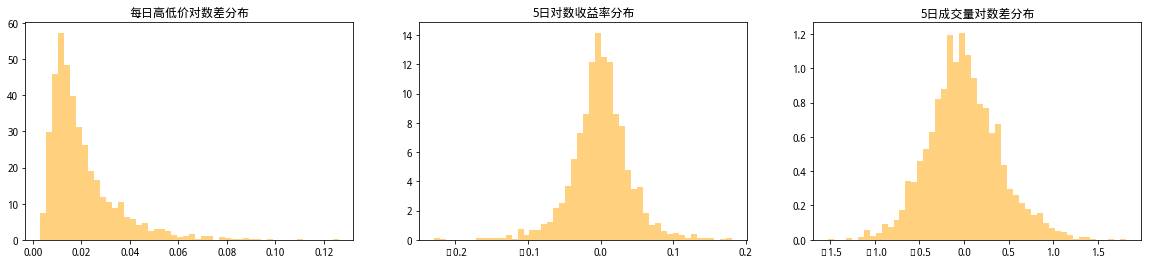

In [5]:
#plot the distribution of characteristic variables
fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(1,3,1)
plt.hist(logdif,50,normed=1,facecolor='orange',alpha=0.5)
plt.title('每日高低价对数差分布')
ax2 = fig.add_subplot(1,3,2)
plt.hist(logret5,50,normed=1,facecolor='orange',alpha=0.5)
plt.title('5日对数收益率分布')
ax3 = fig.add_subplot(1,3,3)
plt.hist(logvoldif5,50,normed=1,facecolor='orange',alpha=0.5)
plt.title('5日成交量对数差分布')
plt.show()

In [6]:
# we see that the fist one does not follow a normal distribution as the HMM model assumes
#use Box-Cox transformation to adjust the distribution of the variable
bc_logdif,_ = stats.boxcox(logdif)
scale_bc_logdif = preprocessing.scale(bc_logdif,axis=0,with_mean=True,with_std=True,copy=False)
scale_logret5 = preprocessing.scale(logret5,axis=0,with_mean=True,with_std=True,copy=False)
scale_logvoldif5 = preprocessing.scale(logvoldif5,axis=0,with_mean=True,with_std=True,copy=False)

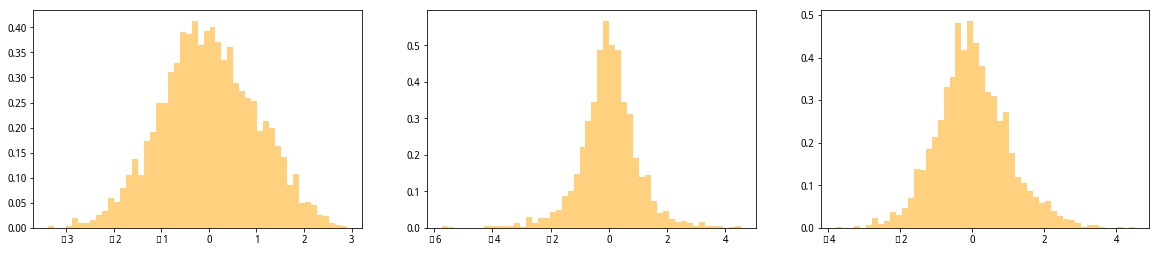

In [7]:
#plot adjusted variables' distributions
#basically follow a normal distribution
fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(1,3,1)
plt.hist(scale_bc_logdif,50,normed=1,facecolor='orange',alpha=0.5)
ax2 = fig.add_subplot(1,3,2)
plt.hist(scale_logret5,50,normed=1,facecolor='orange',alpha=0.5)
ax3 = fig.add_subplot(1,3,3)
plt.hist(scale_logvoldif5,50,normed=1,facecolor='orange',alpha=0.5)
plt.show()

In [8]:
A = np.column_stack([logdif,logret5,logvoldif5])
scaleA = np.column_stack([scale_bc_logdif,scale_logret5,scale_logvoldif5])

In [9]:
#set the number of hidden states equal to 3 and see the prediction of hidden states using HMM
HMMmodel = GaussianHMM(n_components=3,covariance_type='full',n_iter=2000).fit(scaleA)
hidden_states = HMMmodel.predict(scaleA)
hidden_states

array([2, 2, 2, ..., 1, 1, 1])

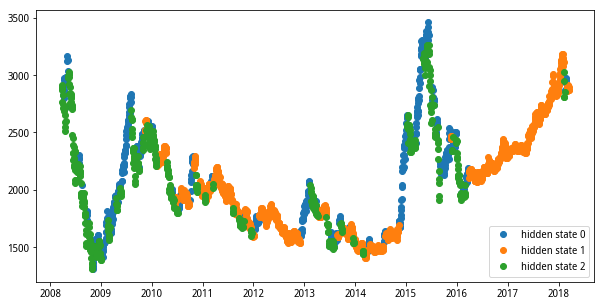

In [10]:
#plot the predicted hidden states
plt.figure(figsize=(10,5))
for i in range(HMMmodel.n_components):
    pos = hidden_states==i
    plt.plot_date(Date[pos],close[pos],'o',label='hidden state %d'%i)
    plt.legend(loc='left')

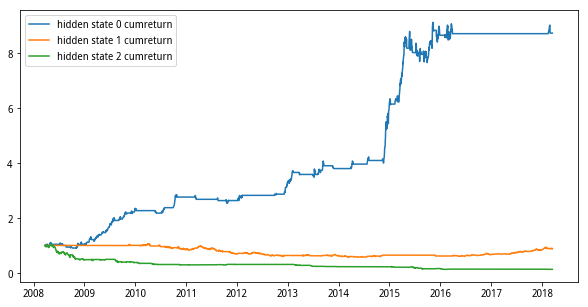

In [11]:
#plot cumulative returns of different hidden states
res = pd.DataFrame({'Date':Date,'logret1':logret1,'states':hidden_states}).set_index('Date')
plt.figure(figsize=(10,5))
for i in range(3):
    pos = (hidden_states==i)
    pos = np.append(0,pos[:-1])
    df = res['logret1']
    res['state %d return'%i] = df.multiply(pos)
    plt.plot_date(Date,np.exp(res['state %d return'%i].cumsum()),'-',label='hidden state %d cumreturn'%i)
    plt.legend(loc='left')

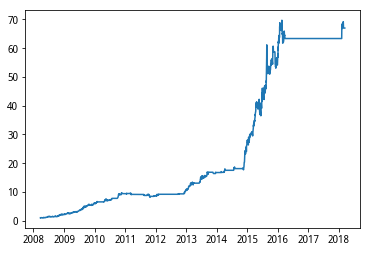

In [12]:
# we can see that hidden state0 performs the best, then we should long tomorrow when the predicted hidden state today is hidden state0
# and hidden state2 performs the worst, then we should short tomorrow when the predicted hidden state today is hidden state2
# plot the cumulative return of this strategy
long = (hidden_states==0)
short = (hidden_states==2)
long = np.append(0,long[:-1])
short = np.append(0,short[:-1])
res['cumreturn'] = df.multiply(long)-df.multiply(short)
plt.plot_date(Date,np.exp(res['cumreturn'].cumsum()),'-')

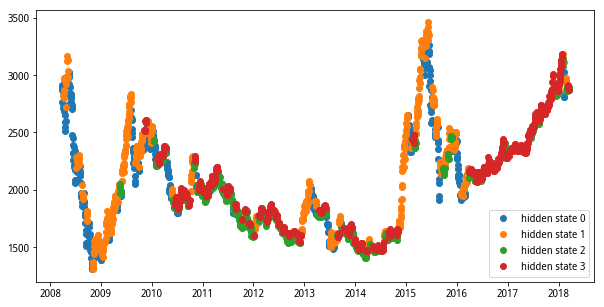

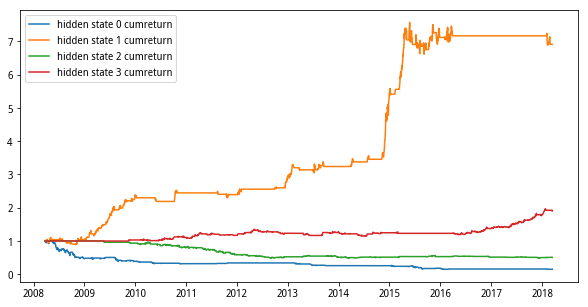

In [13]:
# when the number of hidden states is equal to 4
# do the same analysis as before
HMMmodel2 = GaussianHMM(n_components=4,covariance_type='full',n_iter=2000).fit(scaleA)
hidden_states2 = HMMmodel2.predict(scaleA)
plt.figure(figsize=(10,5))
for i in range(HMMmodel2.n_components):
    pos2 = hidden_states2==i
    plt.plot_date(Date[pos2],close[pos2],'o',label='hidden state %d'%i)
    plt.legend(loc='left')
    
res2 = pd.DataFrame({'Date':Date,'logret1':logret1,'states':hidden_states2}).set_index('Date')
plt.figure(figsize=(10,5))
for i in range(4):
    pos2 = (hidden_states2==i)
    pos2 = np.append(0,pos2[:-1])
    df2 = res2['logret1']
    res2['state %d return'%i] = df2.multiply(pos2)
    plt.plot_date(Date,np.exp(res2['state %d return'%i].cumsum()),'-',label='hidden state %d cumreturn'%i)
    plt.legend(loc='left')

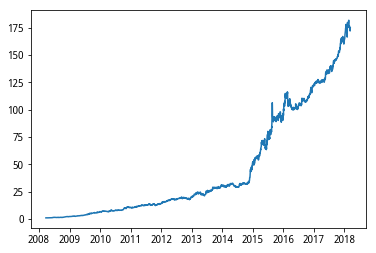

In [14]:
long2 = (hidden_states2==1)+(hidden_states2==3)
short2 = (hidden_states2==0)+(hidden_states2==2)
long2 = np.append(0,long2[:-1])
short2 = np.append(0,short2[:-1])
res2['cumreturn'] = df2.multiply(long2)-df2.multiply(short2)
plt.plot_date(Date,np.exp(res2['cumreturn'].cumsum()),'-')

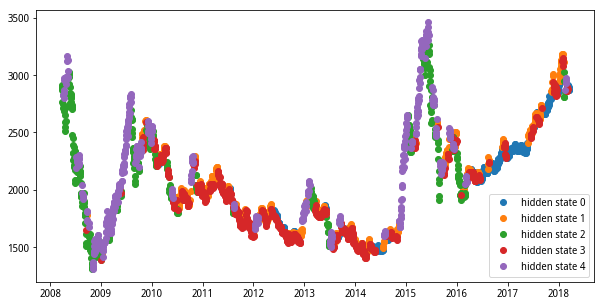

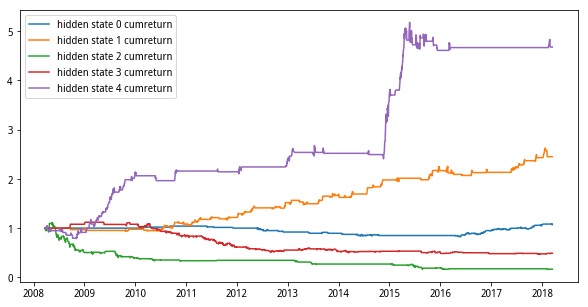

In [58]:
# when the number of hidden states is equal to 5
HMMmodel3 = GaussianHMM(n_components=5,covariance_type='full',n_iter=2000).fit(scaleA)
hidden_states3 = HMMmodel3.predict(scaleA)
plt.figure(figsize=(10,5))
for i in range(HMMmodel3.n_components):
    pos3 = hidden_states3==i
    plt.plot_date(Date[pos3],close[pos3],'o',label='hidden state %d'%i)
    plt.legend(loc='left')
    
res3 = pd.DataFrame({'Date':Date,'logret1':logret1,'states':hidden_states3}).set_index('Date')
plt.figure(figsize=(10,5))
for i in range(5):
    pos3 = (hidden_states3==i)
    pos3 = np.append(0,pos3[:-1])
    df3 = res3['logret1']
    res3['state %d return'%i] = df3.multiply(pos3)
    plt.plot_date(Date,np.exp(res3['state %d return'%i].cumsum()),'-',label='hidden state %d cumreturn'%i)
    plt.legend(loc='left')

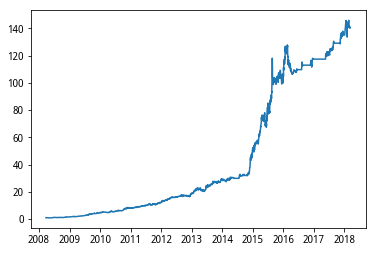

In [60]:
long3 = (hidden_states3==4)+(hidden_states3==1)
short3 = (hidden_states3==3)+(hidden_states3==2)
long3 = np.append(0,long3[:-1])
short3 = np.append(0,short3[:-1])
res3['cumreturn'] = df3.multiply(long3)-df3.multiply(short3)
plt.plot_date(Date,np.exp(res3['cumreturn'].cumsum()),'-')

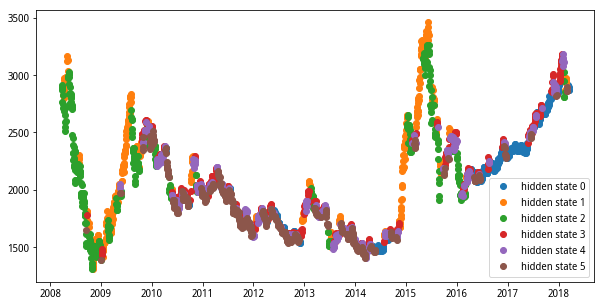

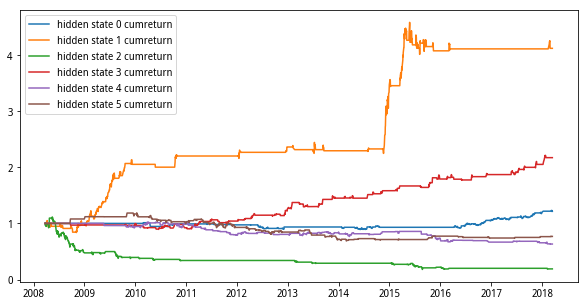

In [61]:
# when the number of hidden states is equal to 6
HMMmodel4 = GaussianHMM(n_components=6,covariance_type='full',n_iter=2000).fit(scaleA)
hidden_states4 = HMMmodel4.predict(scaleA)
plt.figure(figsize=(10,5))
for i in range(HMMmodel4.n_components):
    pos4 = hidden_states4==i
    plt.plot_date(Date[pos4],close[pos4],'o',label='hidden state %d'%i)
    plt.legend(loc='left')
    
res4 = pd.DataFrame({'Date':Date,'logret1':logret1,'states':hidden_states4}).set_index('Date')
plt.figure(figsize=(10,5))
for i in range(6):
    pos4 = (hidden_states4==i)
    pos4 = np.append(0,pos4[:-1])
    df4 = res4['logret1']
    res4['state %d return'%i] = df4.multiply(pos4)
    plt.plot_date(Date,np.exp(res4['state %d return'%i].cumsum()),'-',label='hidden state %d cumreturn'%i)
    plt.legend(loc='left')

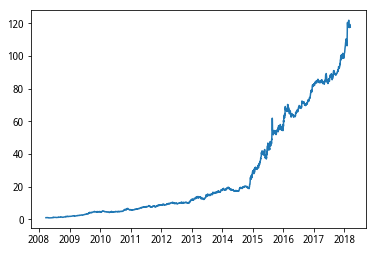

In [62]:
long4 = (hidden_states4==1)+(hidden_states4==3)+(hidden_states4==0)
short4 = (hidden_states4==2)+(hidden_states4==4)+(hidden_states4==5)
long4 = np.append(0,long4[:-1])
short4 = np.append(0,short4[:-1])
res4['cumreturn'] = df4.multiply(long4)-df4.multiply(short4)
plt.plot_date(Date,np.exp(res4['cumreturn'].cumsum()),'-')

In [64]:
# data2 is the CSI 300 index
# here uses API from Joinquant Platform to get the data
data2 = get_price('000300.XSHG',start_date='2008-03-17',end_date='2018-03-17',frequency='daily')
logdif_300 = np.log(np.array(data2['high']))-np.log(np.array(data2['low']))
logret1_300 = np.array(np.diff(np.log(data2['close'])))
logret5_300 = np.log(np.array(data2['close'][5:]))-np.log(np.array(data2['close'][:-5]))
logvoldif5_300 = np.log(np.array(data2['volume'][5:]))-np.log(np.array(data2['volume'][:-5]))
logdif_300 = logdif_300[5:]
logret1_300 = logret1_300[4:]
close_300 = data2['close'][5:]

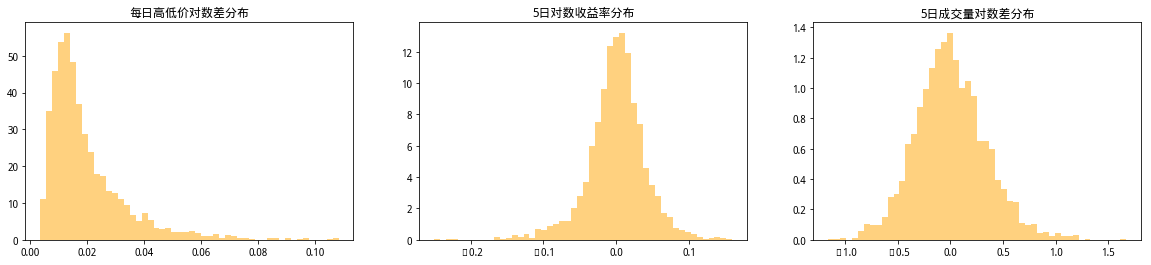

In [65]:
fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(1,3,1)
plt.hist(logdif_300,50,normed=1,facecolor='orange',alpha=0.5)
plt.title('每日高低价对数差分布')
ax2 = fig.add_subplot(1,3,2)
plt.hist(logret5_300,50,normed=1,facecolor='orange',alpha=0.5)
plt.title('5日对数收益率分布')
ax3 = fig.add_subplot(1,3,3)
plt.hist(logvoldif5_300,50,normed=1,facecolor='orange',alpha=0.5)
plt.title('5日成交量对数差分布')
plt.show()

In [66]:
bc_logdif_300,_ = stats.boxcox(logdif_300)
scale_bc_logdif_300 = preprocessing.scale(bc_logdif_300,axis=0,with_mean=True,with_std=True,copy=False)
scale_logret5_300 = preprocessing.scale(logret5_300,axis=0,with_mean=True,with_std=True,copy=False)
scale_logvoldif5_300 = preprocessing.scale(logvoldif5_300,axis=0,with_mean=True,with_std=True,copy=False)

scaleA_300 = np.column_stack([scale_bc_logdif_300,scale_logret5_300,scale_logvoldif5_300])

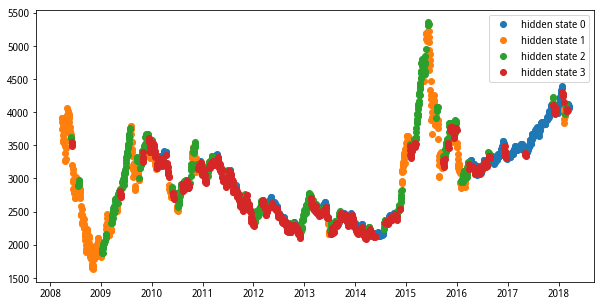

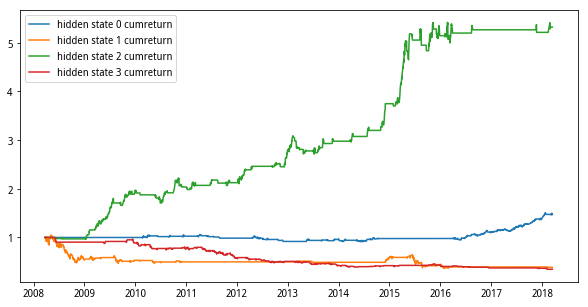

In [70]:
HMMmodel_300 = GaussianHMM(n_components=4,covariance_type='full',n_iter=2000).fit(scaleA_300)
hidden_states_300 = HMMmodel_300.predict(scaleA_300)
plt.figure(figsize=(10,5))
for i in range(HMMmodel_300.n_components):
    pos_300 = hidden_states_300==i
    plt.plot_date(Date[pos_300],close_300[pos_300],'o',label='hidden state %d'%i)
    plt.legend(loc='left')
    
res_300 = pd.DataFrame({'Date':Date,'logret1':logret1_300,'states':hidden_states_300}).set_index('Date')
plt.figure(figsize=(10,5))
for i in range(4):
    pos_300 = (hidden_states_300==i)
    pos_300 = np.append(0,pos_300[:-1])
    df_300 = res_300['logret1']
    res_300['state %d return'%i] = df_300.multiply(pos_300)
    plt.plot_date(Date,np.exp(res_300['state %d return'%i].cumsum()),'-',label='hidden state %d cumreturn'%i)
    plt.legend(loc='left')

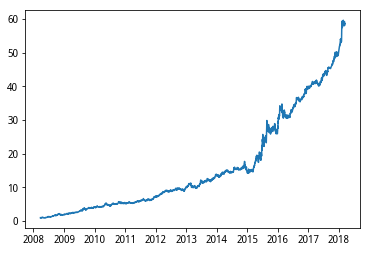

In [71]:
long_300 = (hidden_states_300==2)+(hidden_states_300==0)
short_300 = (hidden_states_300==1)+(hidden_states_300==3)
long_300 = np.append(0,long_300[:-1])
short_300 = np.append(0,short_300[:-1])
res_300['cumreturn'] = df_300.multiply(long_300)-df_300.multiply(short_300)
plt.plot_date(Date,np.exp(res_300['cumreturn'].cumsum()),'-')

In [72]:
# data3 is the CSI 500 index
# here uses API from Joinquant Platform to get the data
data3 = get_price('000905.XSHG',start_date='2008-03-17',end_date='2018-03-17',frequency='daily')
logdif_500 = np.log(np.array(data3['high']))-np.log(np.array(data3['low']))
logret1_500 = np.array(np.diff(np.log(data3['close'])))
logret5_500 = np.log(np.array(data3['close'][5:]))-np.log(np.array(data3['close'][:-5]))
logvoldif5_500 = np.log(np.array(data3['volume'][5:]))-np.log(np.array(data3['volume'][:-5]))
logdif_500 = logdif_500[5:]
logret1_500 = logret1_500[4:]
close_500 = data3['close'][5:]

In [73]:
bc_logdif_500,_ = stats.boxcox(logdif_500)
scale_bc_logdif_500 = preprocessing.scale(bc_logdif_500,axis=0,with_mean=True,with_std=True,copy=False)
scale_logret5_500 = preprocessing.scale(logret5_500,axis=0,with_mean=True,with_std=True,copy=False)
scale_logvoldif5_500 = preprocessing.scale(logvoldif5_500,axis=0,with_mean=True,with_std=True,copy=False)

scaleA_500 = np.column_stack([scale_bc_logdif_500,scale_logret5_500,scale_logvoldif5_500])

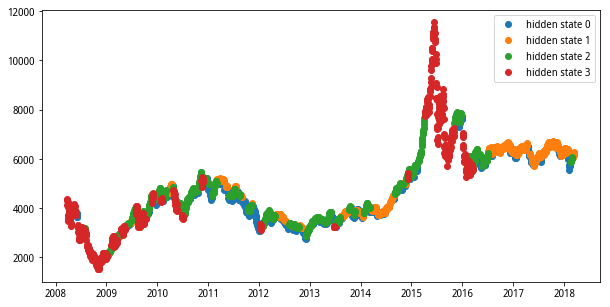

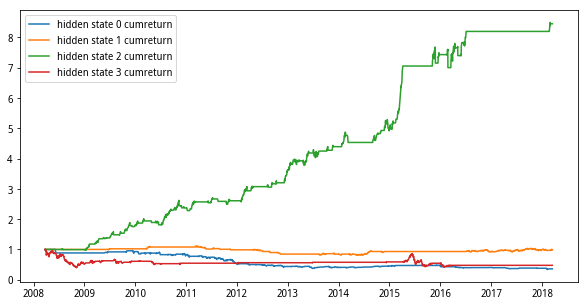

In [76]:
HMMmodel_500 = GaussianHMM(n_components=4,covariance_type='full',n_iter=2000).fit(scaleA_500)
hidden_states_500 = HMMmodel_500.predict(scaleA_500)
plt.figure(figsize=(10,5))
for i in range(HMMmodel_500.n_components):
    pos_500 = hidden_states_500==i
    plt.plot_date(Date[pos_500],close_500[pos_500],'o',label='hidden state %d'%i)
    plt.legend(loc='left')
    
res_500 = pd.DataFrame({'Date':Date,'logret1':logret1_500,'states':hidden_states_500}).set_index('Date')
plt.figure(figsize=(10,5))
for i in range(4):
    pos_500 = (hidden_states_500==i)
    pos_500 = np.append(0,pos_500[:-1])
    df_500 = res_500['logret1']
    res_500['state %d return'%i] = df_500.multiply(pos_500)
    plt.plot_date(Date,np.exp(res_500['state %d return'%i].cumsum()),'-',label='hidden state %d cumreturn'%i)
    plt.legend(loc='left')

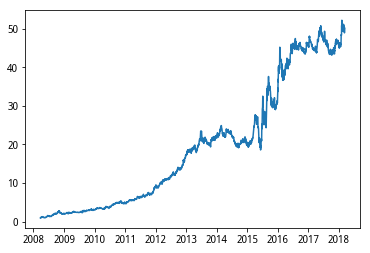

In [77]:
long_500 = (hidden_states_500==2)
short_500 = (hidden_states_500==1)+(hidden_states_500==3)+(hidden_states_500==0)
long_500 = np.append(0,long_500[:-1])
short_500 = np.append(0,short_500[:-1])
res_500['cumreturn'] = df_500.multiply(long_500)-df_500.multiply(short_500)
plt.plot_date(Date,np.exp(res_500['cumreturn'].cumsum()),'-')

In [100]:
# try different characteristic variables
# log returns
logret = np.array(np.diff(np.log(data1['close'])))
# average true range
import talib as ta
ATR = ta.ATR(data1['high'],data1['low'],data1['close'],timeperiod=14)
ATR = [x for x in ATR if str(x)!='nan']
# bias
average_price = ta.SMA(data1['close'],timeperiod=14)
BIAS = (data1['close']-average_price)/average_price
BIAS = [x for x in BIAS if str(x)!='nan']
# moving average volume
shortma = ta.SMA(data1['volume'],timeperiod=12)
longma = ta.SMA(data1['volume'],timeperiod=26)
VOSC = (shortma-longma)/shortma
VOSC = [x for x in VOSC if str(x)!='nan']

logret = logret[24:]
ATR = ATR[11:]
BIAS = BIAS[12:]
close_2 = data1['close'][25:]
Date_2 = pd.to_datetime(data1.index[25:])

In [107]:
logret_1 = np.array(np.diff(np.log(data1['close'])))
logret_1 = logret_1[24:]

In [102]:
A2 = np.column_stack([logret,ATR,BIAS,VOSC])

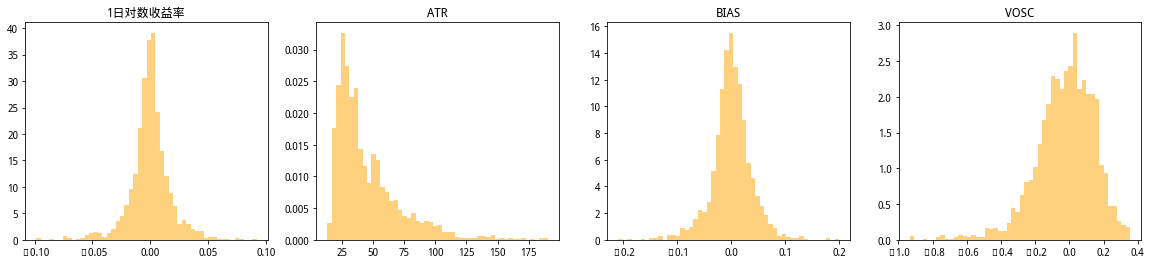

In [104]:
fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(1,4,1)
plt.hist(logret,50,normed=1,facecolor='orange',alpha=0.5)
plt.title('1日对数收益率')
ax2 = fig.add_subplot(1,4,2)
plt.hist(ATR,50,normed=1,facecolor='orange',alpha=0.5)
plt.title('ATR')
ax3 = fig.add_subplot(1,4,3)
plt.hist(BIAS,50,normed=1,facecolor='orange',alpha=0.5)
plt.title('BIAS')
ax4 = fig.add_subplot(1,4,4)
plt.hist(VOSC,50,normed=1,facecolor='orange',alpha=0.5)
plt.title('VOSC')
plt.show()

In [105]:
bc_ATR,_ = stats.boxcox(ATR)
scale_bc_ATR = preprocessing.scale(bc_ATR,axis=0,with_mean=True,with_std=True,copy=False)
scale_logret = preprocessing.scale(logret,axis=0,with_mean=True,with_std=True,copy=False)
scale_BIAS = preprocessing.scale(BIAS,axis=0,with_mean=True,with_std=True,copy=False)
scale_VOSC = preprocessing.scale(VOSC,axis=0,with_mean=True,with_std=True,copy=False)

In [106]:
scaleA2 = np.column_stack([scale_bc_ATR,scale_logret,scale_BIAS,scale_VOSC])

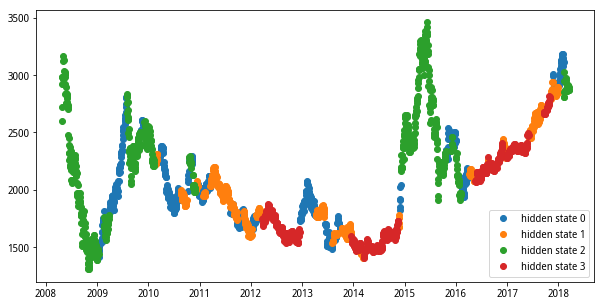

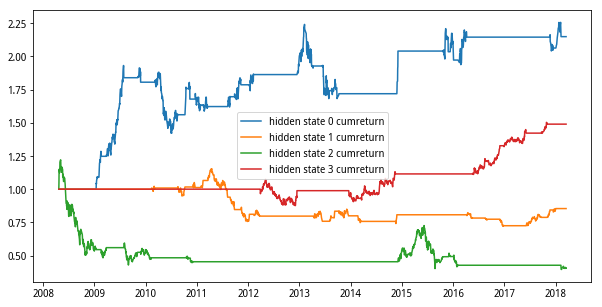

In [109]:
HMMmodel_2 = GaussianHMM(n_components=4,covariance_type='full',n_iter=2000).fit(scaleA2)
hidden_states_2 = HMMmodel_2.predict(scaleA2)
plt.figure(figsize=(10,5))
for i in range(HMMmodel_2.n_components):
    pos_2 = hidden_states_2==i
    plt.plot_date(Date_2[pos_2],close_2[pos_2],'o',label='hidden state %d'%i)
    plt.legend(loc='left')
    
res_2 = pd.DataFrame({'Date':Date_2,'logret1':logret_1,'states':hidden_states_2}).set_index('Date')
plt.figure(figsize=(10,5))
for i in range(4):
    pos_2 = (hidden_states_2==i)
    pos_2 = np.append(0,pos_2[:-1])
    df_2 = res_2['logret1']
    res_2['state %d return'%i] = df_2.multiply(pos_2)
    plt.plot_date(Date_2,np.exp(res_2['state %d return'%i].cumsum()),'-',label='hidden state %d cumreturn'%i)
    plt.legend(loc='left')

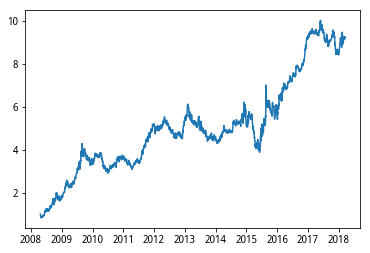

In [110]:
long_2 = (hidden_states_2==0)+(hidden_states_2==3)
short_2 = (hidden_states_2==1)+(hidden_states_2==2)
long_2 = np.append(0,long_2[:-1])
short_2 = np.append(0,short_2[:-1])
res_2['cumreturn'] = df_2.multiply(long_2)-df_2.multiply(short_2)
plt.plot_date(Date_2,np.exp(res_2['cumreturn'].cumsum()),'-')

In [9]:
HMMmodel = GaussianHMM(n_components=4,covariance_type='full',n_iter=2000).fit(scaleA)
hidden_states = HMMmodel.predict(scaleA)
hidden_states

array([2, 2, 2, ..., 0, 3, 3])

In [10]:
# position adjustment period is equal to 30 days
# use the most of the predicted hidden state in 30 days as the period hidden state
hidden_states30 = [np.argmax(np.bincount(hidden_states[i:i+30])) for i in range(0,len(hidden_states),30)]

In [11]:
hidden_states30 = np.array(hidden_states30)

In [12]:
Date30 = [Date[i] for i in range(0,len(Date),30)]
Date30 = pd.to_datetime(Date30)

close30 = [close[i] for i in range(0,len(close),30)]
close30 = pd.DataFrame({'Date':Date30,'close30':close30})

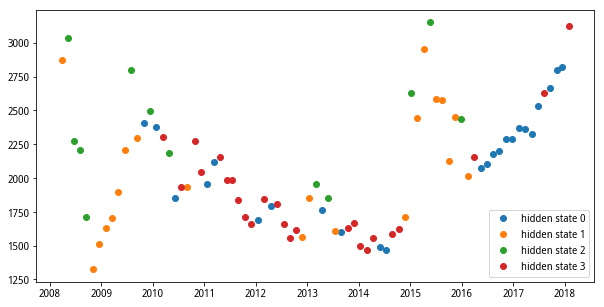

In [13]:
plt.figure(figsize=(10,5))
for i in range(HMMmodel.n_components):
    pos = hidden_states30==i
    plt.plot_date(Date30[pos],close30['close30'][pos],'o',label='hidden state %d'%i)
    plt.legend(loc='left')

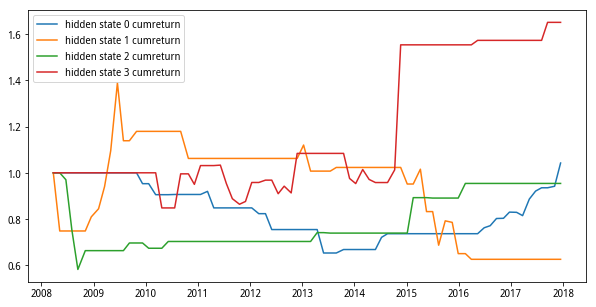

In [14]:
true_logret30 = np.array(np.diff(np.log(close30['close30'])))
res = pd.DataFrame({'Date':Date30[:-1],'true_logret30':true_logret30,'states':hidden_states30[:-1]}).set_index('Date')
plt.figure(figsize=(10,5))
for i in range(4):
    pos = (hidden_states30[:-1]==i)
    pos = np.append(0,pos[:-1])
    df = res['true_logret30']
    res['state %d return'%i] = df.multiply(pos)
    plt.plot_date(Date30[:-1],np.exp(res['state %d return'%i].cumsum()),'-',label='hidden state %d cumreturn'%i)
    plt.legend(loc='left')

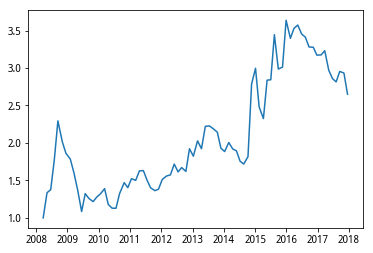

In [15]:
long = (hidden_states30[:-1]==3)
short = (hidden_states30[:-1]==1)+(hidden_states30[:-1]==0)+(hidden_states30[:-1]==2)
long = np.append(0,long[:-1])
short = np.append(0,short[:-1])
res['cumreturn'] = df.multiply(long)-df.multiply(short)
plt.plot_date(Date30[:-1],np.exp(res['cumreturn'].cumsum()),'-')